<a href="https://colab.research.google.com/github/msc-acse/acse-8-miniproject-sigmoid/blob/oliver/KMIST_Aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pylab inline
!pip install pycm albumentations
!pip install pycm livelossplot

from livelossplot import PlotLosses
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import time
import random
import copy

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Populating the interactive namespace from numpy and matplotlib
     |████████████████████████████████| 634kB 3.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
Cuda installed! Running on GPU!


In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True
	
	
class CustomTensorDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        sample = sample.view(1, 28, 28).float()
        if self.transform:
            sample = self.transform(sample)

        return sample, label

		
def normalise_image(data, mean, std):
  " Normalises a set of images using a given mean and standard deviation"
  X_norm = data[:].float()
  X_norm = X_norm - mean
  X_norm = X_norm / std
  return X_norm


class KFoldValidation(SupervisedLearning):
    def __init__(self, X, y, model, optimiser, loss_function, batch_size, test_batch_size,
                 device="cpu", 
                 confusion_matrix=True, 
                 transform=True,
                 seed=42, n_epochs=30,
                 n_folds=3, 
                 early_stop = False,
                 patience = 5,
                 tol = 0.001):

        """
        Class to perform a K-Fold training and validation on a model given a training dataset, an optimiser and a loss function
        Parameters
        ----------
        X: torch.tensor of size (no_images, 28, 28), training images dataset with int values between 0 and 255
        y: torch.tensor of size (no_images), training labels with int values between 0 and 9
        model: nn.Module or inherited class object, model to train
        optimiser: torch.optim object with chosen optimisation technique
        batch_size: int, size of the training batch
        test_batch_size: int, size of validation batch
        device: str, cpu or cuda, where to run the model
        trasform: set to true in order to perform pre-processing with Data Augmentation
        seed: int, seed for reproducibility
        n_epochs: number of epochs to run the model. If early_stop is set to true, then represented the maximum number of epochs
        val_ratio: float, positive number, ratio of training data to perform validation on
        n_folds: int, number of stratified K folds (see scikit learn StratifiedKFold for more info)
        early_stop: bool, if set to true will apply a stopping criteria to the model based on the relative increase in accuracy
        patience: int, number of epochs in a stabilised accuracy necessary to call the early stop
        tol: float, relative tolerance for the early_stop
	
	Returns
	-------
	result: nested list [validation_loss, validation_accuracy, train_loss, train_accuracy] for each fold
        """
        self.device = device
        self.X = X
        self.y = y
        self.model_ori = model.to(self.device)
        self.optimiser_ori = optimiser
        
        self.model = model.to(self.device)
        self.optimiser = optimiser
        self.loss_function = loss_function
        self.X_train = None
        self.X_val = None
        self.y_train = None
        self.y_val = None
        self.transform = transform
        
        
        self.result = None # The cross validation result 
        assert(batch_size > 0 and batch_size < int(0.1 * len(X)))
        self.batch_size = batch_size
        assert(test_batch_size > 0 and test_batch_size < int(0.1 * len(X)))
        
        self.test_batch_size = test_batch_size
        self.n_epochs = n_epochs
        self.seed = seed
        self.n_folds = n_folds
        
        self.mean = None
        self.std = None
        
        self.best_model = None
        self.early_stop = early_stop
        if self.early_stop: self.early =  early_stopping(patience=patience, rel_tol=tol)
  
    def cross_validation(self):
        """
        Performs the KFold cross validation on the training and validation sets
        """
        X = self.X/255.
        y = self.y
        X_train_set = []
        y_train_set = []
        X_val_set = []
        y_val_set = []
        result = []
        
        
        # Store the initial state
        init_state = copy.deepcopy(self.model_ori.state_dict())
        init_state_opt = copy.deepcopy(self.optimiser_ori.state_dict())
        
        # K-fold split
        skf = StratifiedKFold(n_splits= self.n_folds, random_state= self.seed, shuffle=False)
        skf.get_n_splits(X, y)
        for train_index, test_index in skf.split(X, y):
            print("TRAIN:", train_index, "TEST:", test_index)
            X_train_set.append(X[train_index]) 
            X_val_set.append(X[test_index])
            y_train_set.append(y[train_index])
            y_val_set.append(y[test_index])
        
        
        for i, data in enumerate(X_train_set):
            self.mean = data.numpy().mean(axis=(0,1,2))#/255
            self.std = data.numpy().std(axis=(0,1,2))#/255
            print(self.mean," " ,self.std)
            
            # create train_transform
            if self.transform:
                train_transform =  transforms.Compose([
                                  transforms.ToPILImage(),
                                  transforms.RandomRotation(10),
                                  transforms.RandomCrop(28, pad_if_needed=True),
                                  transforms.ToTensor(), 
                                  transforms.Normalize(mean=[self.mean], std=[self.std])
                                  ])
            else:
                train_transform =  transforms.Compose([
                                  transforms.Normalize(mean=[self.mean], std=[self.std])
                                  ])
            val_transform = transforms.Compose([
                                transforms.Normalize(mean=[self.mean], std=[self.std])
                                ])
            
            
            # Create Datasets
            train_set = CustomTensorDataset(X_train_set[i], y_train_set[i].long(), transform=train_transform)
            validation_set = CustomTensorDataset(X_val_set[i], y_val_set[i].long(), transform=val_transform)
            
            # Reset the model 
            self.model.load_state_dict(init_state)
            self.optimiser.load_state_dict(init_state_opt)
            
            result.append(self._train_validation(train_set, validation_set))
            print("The ", i, " fold finished.")
        ave_result = np.array(result).mean(axis=0)
        
        print(" ")
        print("Result:")
        print("----------------------------")
        print("Average validation loss for ", self.n_folds ," folds is ", ave_result[0])
        print("Average validation accuracy for ", self.n_folds ," folds is ", ave_result[1])
        print("Average train loss for ", self.n_folds ," folds is ", ave_result[2])
        print("Average train accuracy for ", self.n_folds ," folds is ", ave_result[3])
        return result
      
    def _train_validation(self, train_set, validation_set, plot=True):
        """ Train model in different folds """
        t = time.time()

        train_loader = DataLoader(train_set, batch_size= self.batch_size, shuffle=True, num_workers=4)
        validation_loader = DataLoader(validation_set, batch_size= self.test_batch_size, shuffle=False, num_workers=4)
        #test_loader = DataLoader(cifar_test, batch_size=test_batch_size, shuffle=False, num_workers=4)
        if plot:
            liveloss = PlotLosses()
        
        best_val_acc = 0 # Initialize the best score
        
        for epoch in range(self.n_epochs):
            logs = {}
            train_loss, train_accuracy = super().train(train_loader)
            logs['' + 'log loss'] = train_loss.item()
            logs['' + 'accuracy'] = train_accuracy.item()
            validation_loss, validation_accuracy = super().validate(validation_loader)
            logs['val_' + 'log loss'] = validation_loss.item()
            logs['val_' + 'accuracy'] = validation_accuracy.item()
            if plot:
                liveloss.update(logs)
                liveloss.draw()
            logs['time'] = time.time() - t
            
            # Checking stopping criteria
            if self.early_stop: self.early(validation_accuracy)
                
            # Saving the best weights    
            if validation_accuracy.item() > best_val_acc:  
              self.best_model = self.model
              best_val_acc = validation_accuracy.item()
                
            # If the stopping criteria is met  
            if self.early_stop:
                if self.early.stop: 
                    #self.model = self.best_model
                    self.logs = logs
                    print("The best model is found.")
                    break
            self.logs = logs
        self.result = [validation_loss.item(), validation_accuracy.item(), train_loss.item(), train_accuracy.item()]
        return self.result

	  
class early_stopping:
  """
  Counter to implement early stopping
  If validation accuracy has not relative improved above
  a absolute tolerance set by the user than it breaks the 
  training
  If rel_tol is set to 0 it becomes a common counter
  """
  def __init__(self, patience, rel_tol, verbose=True):

    
    self.patience = patience
    self.rel_tol = rel_tol
    self.verbose = verbose
    self.best_score = 0
    self.counter = 0
    self.stop = False

  
  def __call__(self, score):
    
    # If the score is under the required relative tolerance
    # increase the counter is incremented
    if score < self.best_score * (1 + self.rel_tol):
        self.counter += 1
    else:
        self.counter = 0
        
        
    if score > self.best_score:
      self.best_score = score

      
    if self.counter >= self.patience:
      self.stop = True    
      
    if self.verbose:
      print("Count:", self.counter)
	
	
	
def evaluate(X_test, model, norm_mean, norm_std, ensemble=False, test_batch_size=30, test_transform=None, device="cpu", save_to_csv=False, path="./foo.csv"):
      """
      This method takes a tensor of images and a trained model and returns the predicted labels
      from those images
      Params
      ------
        X_test: torch.tensor of size (no_images, 28, 28), test images dataset with values prenormalised between 0 and 1 (i.e. divided by 255)
        model: nn.Module or inherited class object
        norm_mean: float, mean value of training set to normalise the test set
        norm_std: float, standard deviation value of the training set to normalise the test set
        ensemble: bool, set to true if performing ensembled models, prevents Softmax to be called twice
        test_batch_size: int, defines the size of the batch for the test datset
        test_transform: transforms.Compose list of transforms to apply to the dataset
        device: str, on which device to run the model, cpu or cuda
        save_to_csv: bool, option to save predictions to csv in format (index, prediction)
        path: str, path to save string 
        
      Returns
      -------
        y_preds: np.array of predictios made on X_test by the trained model
        
      """
      model.eval()
      model.to(device)
      y_test = torch.zeros_like(X_test)
      test_dataset = CustomTensorDataset(normalise_image(X_test.float(), norm_mean, norm_std), y_test, transform=test_transform)
      test_data_loader = DataLoader(test_dataset, test_batch_size, shuffle=False)
      
      y_preds = []
      for X, y in test_data_loader:
          with torch.no_grad():
              X, y = X.to(device), y.to(device)
              a2 = model(X)
              if ensemble: y_pred = a2.max(1)[1]
              else: y_pred = F.log_softmax(a2, dim=1).max(1)[1]
              y_preds.append(y_pred.cpu().numpy())
            
      y_preds =  np.concatenate(y_preds, 0)
      
      sub = pd.DataFrame(data={'Category': y_preds})
      sub.index.name = "Id" 
      if save_to_csv:
        sub.to_csv(path)
        
      return y_preds, sub

	   
def model_save(model, name, path, val_acc):
  """Saving function to keep track of models"""
  val = str(val_acc)[2:5]
  path = path + name + '_' + val + '.pth'
  print("Saving model under:", path)
  torch.save(model, path)
  return


def model_load(path, model_name):
  """Loading function for models from google drive"""
  model = torch.load(path + model_name + '.pth')
  return model


def param_strip(param):
  """Strips the key text info out of certain parameters"""
  return str(param)[:str(param).find('(')]


def full_save(path, name, model, optimiser, loss_function, early_stop_tol, n_epoch, lr, momentum, weight_decay, n_folds, train_trans, val_acc, val_loss, train_time, test_acc=None):
  """Saves the models weights and hyperparameters to a pth file and csv file"""
  if train_trans: train_trans="True"
  else: train_trans="False"
  ind = ["Model, Optimiser, Loss Function, Early Stop Tol, Epochs, Learning Rate, Momentum, Weight Decay, nFolds, Augmentations, Val Acc, Val Loss, Training Time, Test Acc"]
  row = [param_strip(model), param_strip(optimiser), param_strip(loss_function), early_stop_tol, n_epoch, lr, momentum, weight_decay, n_folds, train_trans,val_acc, val_loss, train_time, test_acc]
  s = [str(i) for i in row] 
  row = [",".join(s)]
  model_save(model, name, path, val_acc)
  np.savetxt(path + name + '_' + str(val_acc)[2:5] + ".csv", np.r_[ind, row], fmt='%s', delimiter=',')
  return


class ensemble_net(nn.Module):
    """A classifier class that takes individiual pretrained models 
    and aggregates their output values to create ensemble voting
      Params
    ------
      models: a list of model objects
    Returns
    -------
      x_out: a probability vector for the output classes
    """
    def __init__(self, models):
        super(ensemble_net, self).__init__()
        self.models = models
        self.soft = nn.Softmax(dim=1)
    def forward(self, x):
        num = len(self.models)
        for ind, model in enumerate(self.models):
          if ind ==0:
            x1 = model(x)
            x_out = self.soft(x1)
          else:
            x1 = model(x)
            x_out += self.soft(x1)
        x_out /= num
        return x_out
    def inspect(self):
      """Returns the composition of the ensemble model"""
      for model in self.models:
        print(model)
      return None


def accuracy_check(y_preds, y):
  """Returns the accuracy on the validation set"""
  return len(np.where((y_preds==y.numpy())==True)[0])/len (y_preds)


In [0]:
class SupervisedLearning:
    def __init__(self, X, y, model, optimiser, loss_function, batch_size, test_batch_size,
                 device="cpu", 
                 transform=False, 
                 seed=42, n_epochs=30,
                 val_ratio=0.1, n_splits=1, 
                 early_stop = True,
                 patience = 5,
                 tol = 0.001):
      """
      Class to perform training and validation on a model given a training dataset, an optimiser and a loss function
      Parameters
      ----------
      X: torch.tensor of size (no_images, 28, 28), training images dataset with int values between 0 and 255
      y: torch.tensor of size (no_images), training labels with int values between 0 and 9
      model: nn.Module or inherited class object, model to train
      optimiser: torch.optim object with chosen optimisation technique
      batch_size: int, size of the training batch
      test_batch_size: int, size of validation batch
      device: str, cpu or cuda, where to run the model
      trasform: set to true in order to perform pre-processing with Data Augmentation
      seed: int, seed for reproducibility
      n_epochs: number of epochs to run the model. If early_stop is set to true, then represented the maximum number of epochs
      val_ratio: float, positive number, ratio of training data to perform validation on
      n_splits: int, number of stratified shuffled spltis (see scikit learn stratified shuffle split for more info)
      early_stop: bool, if set to true will apply a stopping criteria to the model based on the relative increase in accuracy
      patience: int, number of epochs in a stabilised accuracy necessary to call the early stop
      tol: float, relative tolerance for the early_stop
      """
      
      self.device = device
      
      self.X = X.float()/255.
      self.y = y
      
      self.model = model.to(self.device)
      self.optimiser = optimiser
      self.loss_function = loss_function
      
      self.X_train = None
      self.X_val = None
      
      self.y_train = None
      self.y_val = None
      
      self.transform = transform
      
      assert(batch_size > 0 and batch_size < int(0.1 * X.size()[0]))
      self.batch_size = batch_size
      assert(test_batch_size > 0 and test_batch_size < int(0.1 * X.size()[0]))
      self.test_batch_size = test_batch_size
      self.n_epochs = n_epochs
      self.seed = seed
      self.val_ratio = val_ratio
      self.n_splits = n_splits

      self.trained_full=False
      
      self.mean_full = None
      self.std_full = None
      
      self.mean = None
      self.std = None
      
      self.logs = None # saves the liveloss object data
      
      self.best_model = None
      
      self.early_stop = early_stop
      if self.early_stop: self.early =  early_stopping(patience=patience, rel_tol=tol)  
      
      
    def split_data(self):
      """
      Splits training data into training and validation sets given an user-specified validation ratio
      """
      sss = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.val_ratio, random_state=0)
      sss.get_n_splits(self.X, self.y)

      for train_index, val_index in sss.split(self.X, self.y):
        self.X_train, self.X_val = self.X[train_index], self.X[val_index]
        self.y_train, self.y_val = self.y[train_index], self.y[val_index]
        
      return None
      
      
      
    def train(self, train_data_loader):
      """
      Trains a model given a train data loader
      """
      self.model.train()                # set model to train mode
      
      train_loss, train_accuracy = 0., 0.

      for Xtr, ytr in train_data_loader:# X and y are data inside a batch specified
                                        # at train_data_loader

        Xtr = Xtr.to(self.device)
        ytr = ytr.to(self.device)
        

        self.optimiser.zero_grad()           # reset gradients
        zn = self.model(Xtr)                 # perform forward pass
        

        loss = self.loss_function(zn, ytr)   # compute loss value over batch
        loss.backward()                 # perform backward pass
        train_loss += (loss * Xtr.size()[0]).detach().cpu().numpy()
        

        y_pred = F.log_softmax(zn, dim=1).max(1)[1]
        train_accuracy += accuracy_score(ytr.cpu().numpy(), y_pred.detach().cpu().numpy())*Xtr.size()[0]
        
        self.optimiser.step()               # optimisation step
        
      return train_loss/len(train_data_loader.dataset), train_accuracy/len(train_data_loader.dataset)
    
    
    
    def validate(self, val_data_loader):
      """
      Computes the accuracy and loss of a trained model based on a data loader
      """
      self.model.eval()                     # set model to evaluation mode
      
      validation_loss, validation_accuracy = 0., 0.
      
      for Xv, yv in val_data_loader:
        with torch.no_grad():
          
          Xv, yv = Xv.to(self.device), yv.to(self.device)
          
          zn = self.model(Xv)
          loss = self.loss_function(zn, yv)
          validation_loss += (loss * Xv.size(0)).detach().cpu().numpy()
          
          y_pred = F.log_softmax(zn, dim=1).max(1)[1]
          validation_accuracy += accuracy_score(yv.cpu().numpy(), y_pred.detach().cpu().numpy())*Xv.size(0)

            
      return validation_loss/len(val_data_loader.dataset), validation_accuracy/len(val_data_loader.dataset)
        
      
    
    def train_wrapper(self, train_full=False, plot_loss=True):
      """
      Calls class methods in order to perform training
      Parameters
      ----------
      train_full: bool, if set to False, will split the data into training and validation. 
                  If true, training will be performed on the entire training dataset
      plot_loss : bool, if set to true will plot the loss and accuracies over each epoch
      """

      # start timer
      t = time.time()
      
      # set seed
      set_seed(int(self.seed))
      
      
      if train_full: # train with full data (train + validation)
        # find mean and std of training data
        mean, std = self.find_mean_std(train_full)
        
        # create train_transform
        if self.transform:
          train_transform =  transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.RandomRotation(30),
                              transforms.RandomCrop(28, pad_if_needed=True),
                              transforms.ToTensor(), 
                              transforms.Normalize(mean=[mean], std=[std])
                              ])
        else:
          train_transform =  transforms.Compose([
                              transforms.Normalize(mean=[mean], std=[std])
                              ])
        
        # create dataloaders
        train_dataset = CustomTensorDataset(self.X, self.y, transform=train_transform)
        train_data_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        # save best train accuracy
        best_train_acc = 0
        
        # train and validate
        if plot_loss: liveloss = PlotLosses()
        for epoch in range(self.n_epochs):
            logs = {}
            train_loss, train_accuracy = self.train(train_data_loader)

            if plot_loss:
              logs['' + 'log loss'] = train_loss.item()
              logs['' + 'accuracy'] = train_accuracy.item()
              logs['val_' + 'log loss'] = 1.
              logs['val_' + 'accuracy'] = 1.
              liveloss.update(logs)
              liveloss.draw()
              logs['time'] = time.time() - t
              
            # Checking stopping criteria
            if self.early_stop: self.early(train_accuracy)
                
            # Saving the best weights    
            if train_accuracy.item() > best_train_acc:  
              # Saving the models weights to best model
              self.best_model = self.model
              best_train_acc = train_accuracy.item()
            
            # If the stopping criteria is met  
            if self.early_stop:
              if self.early.stop: 
                  self.logs = logs
                  self.model = self.best_model
                  break

            # store logs
            self.logs = logs  
                  
        self.trained_full=True

        # Save best model
        self.model = self.best_model

      else:
        # split data
        self.split_data()
        
        # find mean and std of training data
        mean, std = self.find_mean_std(train_full)
        
        
        # create transforms
        if self.transform:
          train_transform =  transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.RandomRotation(10),
                              transforms.RandomCrop(28, pad_if_needed=True),
                              transforms.ToTensor(), 
                              transforms.Normalize(mean=[mean], std=[std])
                              ])
        else:
          train_transform =  transforms.Compose([
                              transforms.Normalize(mean=[mean], std=[std])
                              ])
        
        # apply normalisation to validation set    
        val_transform = transforms.Compose([
                            transforms.Normalize(mean=[mean], std=[std])
                            ])

        # create datasets and dataloaders
        train_dataset = CustomTensorDataset(self.X_train, self.y_train, transform=train_transform)
        train_data_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        val_dataset = CustomTensorDataset(self.X_val, self.y_val, transform=val_transform)
        val_data_loader = DataLoader(val_dataset, batch_size=self.test_batch_size, shuffle=False)
        
        # store best validation accuracy
        best_val_acc = 0
            
        # train and validate
        if plot_loss: liveloss = PlotLosses()
        for epoch in range(self.n_epochs):
            logs = {}
            train_loss, train_accuracy = self.train(train_data_loader)
            val_loss, val_accuracy = self.validate(val_data_loader)
            
            if plot_loss:
              logs['' + 'log loss'] = train_loss.item()
              logs['' + 'accuracy'] = train_accuracy.item()
              logs['val_' + 'log loss'] = val_loss.item()
              logs['val_' + 'accuracy'] = val_accuracy.item() # liveloss wants it plotted
              liveloss.update(logs)
              liveloss.draw()
              logs['time'] = time.time() - t 
            
            # Checking stopping criteria
            if self.early_stop: self.early(val_accuracy)
                
            # Saving the best weights    
            if val_accuracy.item() > best_val_acc:  
              self.best_model = self.model
              best_val_acc = val_accuracy.item()
            
            # If the stopping criteria is met  
            if self.early_stop:
              if self.early.stop: 
                  self.logs = logs
                  self.model = self.best_model
                  break

            self.logs = logs

        self.trained_full=False
        
        # Save best model
        self.model = self.best_model
              
      return None
            
            

    def find_mean_std(self, full_training=False):
      """
      Finds the mean and std values the training set
      Mean is already relative to a prenormalised set, with values between 0 and 1
      """
      mean = 0
      std = 0
      
      if full_training:
        mean = torch.mean(self.X)
        std = torch.std(self.X)
        
        self.mean_full = mean
        self.std_full = std
        
      else:
        mean = torch.mean(self.X_train)
        std = torch.std(self.X_train)
        self.mean = mean
        self.std = std
        
      return mean, std

In [0]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    # The implementation of the LeNet5 architecture
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 120)
    self.f6 = nn.Linear(120, 84)
    self.output = nn.Linear(84, 10)
    self.act = nn.ReLU()
    
  def forward(self, x):
    # Applying the ReLU activation function throughout the net
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
    x = self.act(self.c5(x))
    x = self.act(self.f6(x))
    return self.output(x)
  

In [0]:
class AlexNetMod(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNetMod, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=4, padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [14]:
# Import Data
path="sigmoid/data/"
train_data = np.load(path+"kmnist-train-imgs.npy")
test_data = np.load(path+"kmnist-test-imgs.npy")
train_labels = np.load(path+"kmnist-train-labels.npy")
classmap = pd.read_csv(path+"kmnist_classmap.csv")

# Tensor of training data
X = torch.from_numpy(train_data).float()
# Tensor of training labels
y = torch.from_numpy(train_labels).long()
#  Tensor of test data
X_test = torch.from_numpy(test_data).float()

# Size Check
print("Train Data:", X.size())
print("Test Data:", X_test.size())
print("Train Labels:", y.size())

Train Data: torch.Size([60000, 28, 28])
Test Data: torch.Size([10000, 28, 28])
Train Labels: torch.Size([60000])


In [0]:
from albumentations import Compose, RandomCrop, Normalize, Rotate, GaussNoise, RandomContrast, ShiftScaleRotate
from albumentations.pytorch import ToTensor

albumentations_transform = Compose([
    RandomCrop(24, 24),
    Normalize(mean=[mean], std=[std]),
    Rotate(limit=30, p=0.5)
])


# GaussNoise()
# RandomContrast()
# ToTensor()
# ShiftScaleRotate(rotate_limit=30)

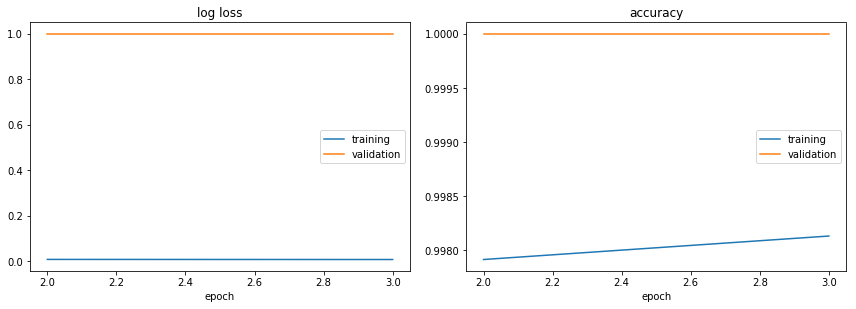

log loss:
training   (min:    0.007, max:    0.009, cur:    0.007)
validation (min:    1.000, max:    1.000, cur:    1.000)

accuracy:
training   (min:    0.997, max:    0.998, cur:    0.998)
validation (min:    1.000, max:    1.000, cur:    1.000)
Count: 0

 {'log loss': 0.006752295406659444, 'accuracy': 0.9981333333333333, 'val_log loss': 1.0, 'val_accuracy': 1.0, '_i': 3, 'time': 134.6549518108368}


In [20]:
#
# Model Name
MODEL_NAME = "alex_aug_full_111"

# Hyperparameters
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 3
patience=5
early_stop_tol = 0.000
n_folds=0
weight_decay=0

# Define/Load Model, Optimiser and Loss Function
alexnet = model_load("/content/gdrive/My Drive/Sigmoid/Models/", MODEL_NAME)
lr_dic = []
for i in range(0, len(alexnet.classifier)-1):
  lr_dic.append({'params': alexnet.classifier[i].parameters(), 'lr': 0.0})
for i in range(0, len(alexnet.features)):
  lr_dic.append({'params': alexnet.features[i].parameters(), 'lr': 0.0})
lr_dic.append({'params': alexnet.classifier[-1].parameters(), 'lr': lr})
optimiser = torch.optim.SGD(lr_dic, momentum=momentum, weight_decay=0)

loss_function = nn.CrossEntropyLoss()

# Create Supervised Learning Object
learning = SupervisedLearning(X, y, alexnet, optimiser, loss_function, batch_size, test_batch_size,
                 device=device,
                 transform=True, 
                 seed=42, n_epochs=n_epochs,
                 val_ratio=0.1, n_splits=n_folds+1, 
                 early_stop = True,
                 patience = patience,
                 tol = early_stop_tol)

# Train model with validation
learning.train_wrapper(train_full=True)
print("\n", learning.logs)

In [21]:
 from torchvision.datasets import KMNIST
 test = KMNIST("./", train=False, download=True)

0it [00:00, ?it/s]

18169856it [00:03, 5155650.99it/s]                              


Extracting ./KMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 84063.09it/s]                            
0it [00:00, ?it/s]

Extracting ./KMNIST/raw/train-labels-idx1-ubyte.gz


3047424it [00:01, 1978132.32it/s]                             
0it [00:00, ?it/s]

Extracting ./KMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 31788.55it/s]            

Extracting ./KMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
m, s = torch.mean(X/255.), torch.std(X/255.)
y_pred, sub = evaluate(X_test/255., alexnet, m, s, test_batch_size=1000)

In [29]:
print(y_pred)
print(m,s)
accuracy_check(y_pred, test.targets)

[2 9 3 ... 9 4 2]
tensor(0.1918) tensor(0.3483)


0.9722